In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from safety_enforcer import SafetyEnforcer

In [26]:
filename = "data-20230207210817-0.03.pkl"
# pd.DataFrame(pd.read_pickle(filename)).to_csv("{}.csv".format(filename), index=False)
df = pd.DataFrame(pd.read_pickle(filename))

In [27]:
print(df.columns)

Index(['time', 'state', 'action', 'is_shielded', 'command', 'q_array'], dtype='object')


In [28]:
time_shield_on = []
time_is_shielded = []
time_no_shield = []

freq_shield_on = []
freq_is_shielded = []
freq_no_shield = []

for i in range(1, len(df)):
    if df.iloc[i]["command"] == "8s":
        if df.iloc[i]["is_shielded"] is True:
            time_is_shielded.append(df.iloc[i]["time"])
            freq_is_shielded.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))
        else:
            time_shield_on.append(df.iloc[i]["time"])
            freq_shield_on.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))
    else:
        time_no_shield.append(df.iloc[i]["time"])
        freq_no_shield.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))


/tmp/ipykernel_73096/453747960.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  freq_no_shield.append(1.0 / (df.iloc[i]["time"] - df.iloc[i-1]["time"]))


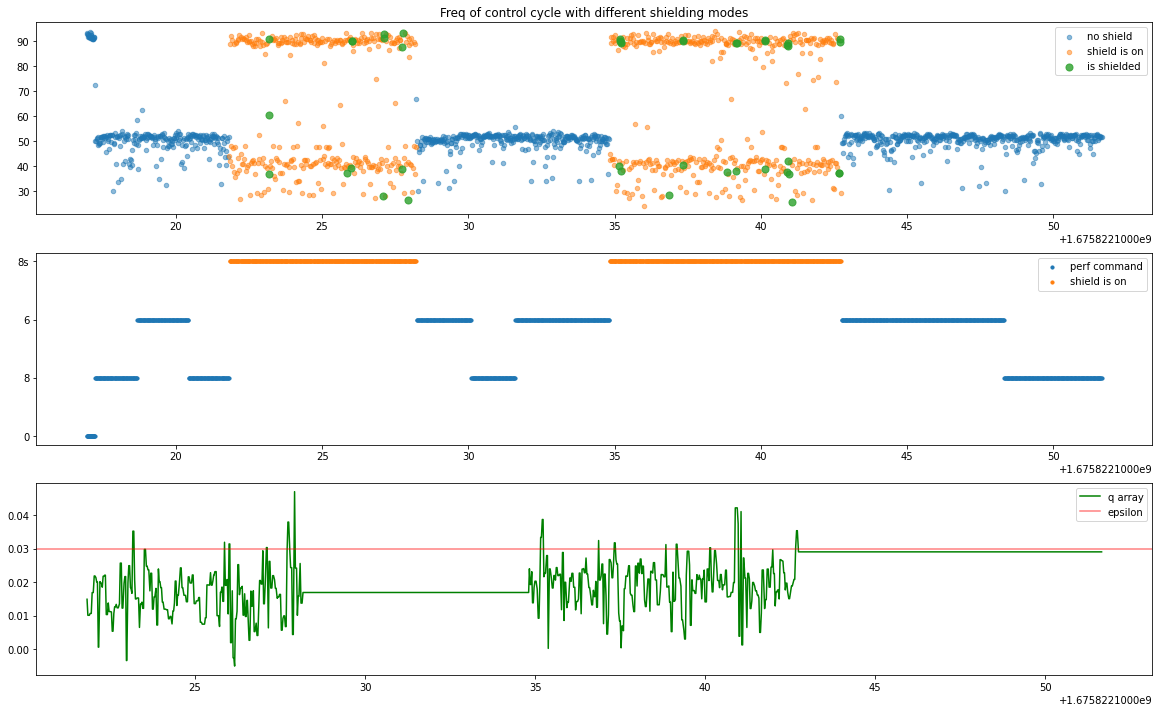

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(20, 12))
ax[0].set_title("Freq of control cycle with different shielding modes")
ax[0].scatter(time_no_shield, freq_no_shield, label="no shield", alpha=0.5, s=20)
ax[0].scatter(time_shield_on, freq_shield_on, label="shield is on", zorder=5, alpha=0.5, s=20)
ax[0].scatter(time_is_shielded, freq_is_shielded, label="is shielded", zorder=10, alpha=0.8, s=50)
ax[1].scatter(df["time"][df["command"] != "8s"], df["command"][df["command"] != "8s"], s=10, label="perf command")
ax[1].scatter(df["time"][df["command"] == "8s"], df["command"][df["command"] == "8s"], s=10, label="shield is on")
ax[2].plot(df["time"], df["q_array"], color="green", label="q array")
ax[2].axhline(0.03, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

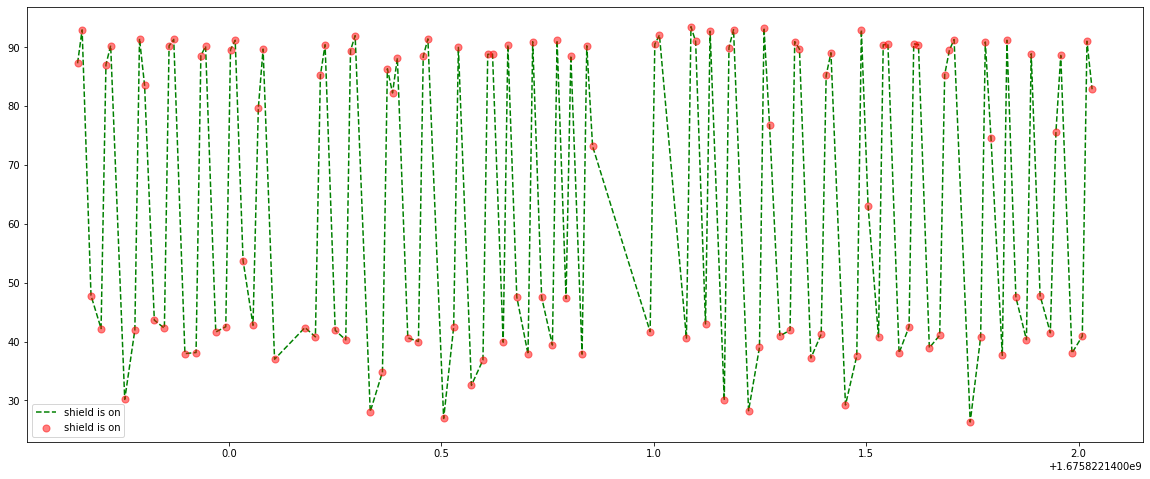

In [31]:
lim_low = 580
lim_high = 700

plt.figure(figsize=(20, 8))
plt.plot(time_shield_on[lim_low:lim_high], freq_shield_on[lim_low:lim_high], label="shield is on", color="green", ls="--")
plt.scatter(time_shield_on[lim_low:lim_high], freq_shield_on[lim_low:lim_high], label="shield is on", zorder=5, alpha=0.5, s=50, color="red")
plt.legend()
plt.show()

In [100]:
"""
x, y, z,
v_x, v_y, v_z,
roll, pitch, yaw,
ang_vel_x, ang_vel_y, ang_vel_z, 
joint_pos
joint_vel
"""
state_array = np.array(df["state"].to_list())
action_array = np.array(df["action"].to_list())
action_array = action_array.reshape((len(action_array), 4, 3))
action_array[:, :, [0, 1]] = action_array[:, :, [1, 0]]
action_array = action_array.reshape((len(action_array), 12))

In [110]:
action_array[100]

array([-0.03978469,  0.75067752,  1.64023762, -0.19375141,  0.92643587,
        1.28872091, -0.01642764,  0.92643587,  1.28872091,  0.10600711,
        0.75067752,  1.64023762])

In [111]:
state_array[100,12:24]

array([ 1.41799998,  0.92000002, -0.133     ,  1.39400005,  0.80000001,
        0.053     ,  1.49899995,  0.68099999,  0.013     ,  1.40499997,
        0.94400001,  0.059     ])

In [90]:
shielding_status = np.array([1 if x is True else 0 for x in df["is_shielded"]])
shielding_command = np.array([1 if x == "8s" else 0 for x in df["command"]])

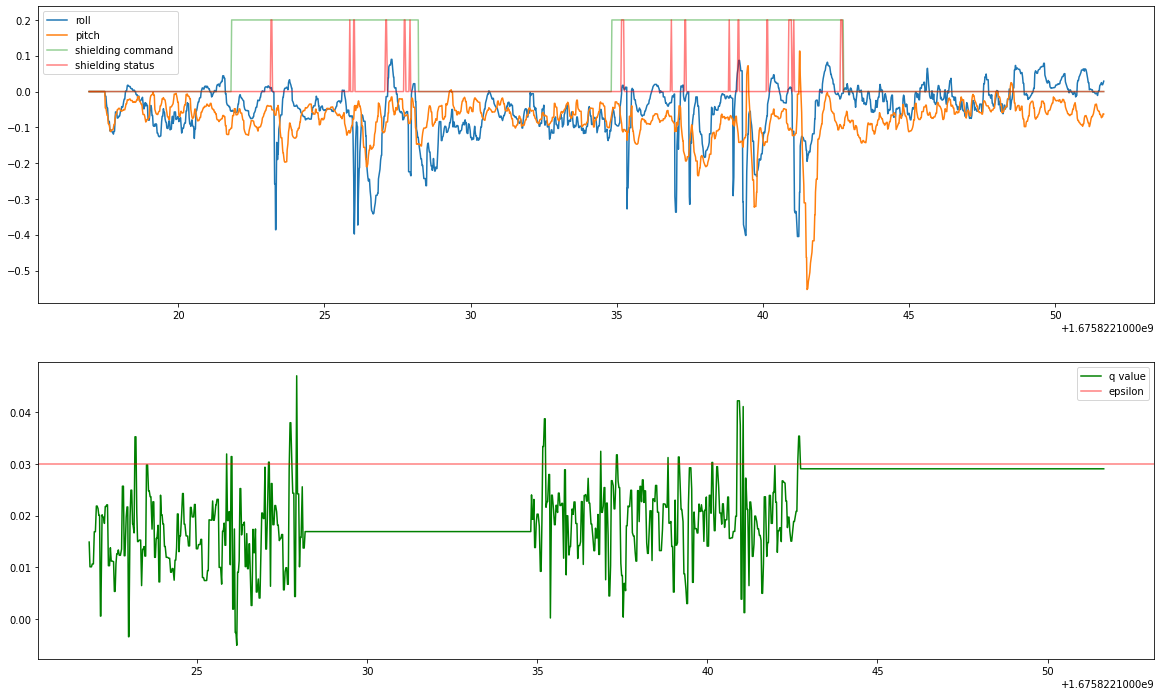

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].plot(df["time"], state_array[:, 6], label="roll")
ax[0].plot(df["time"], state_array[:, 7], label="pitch")
ax[0].plot(df["time"], shielding_command * 0.2, label="shielding command", alpha=0.5)
ax[0].plot(df["time"], shielding_status * 0.2, label="shielding status", color="red", alpha=0.5)
ax[1].plot(df["time"], df["q_array"], label="q value", color="green")
ax[1].axhline(0.03, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

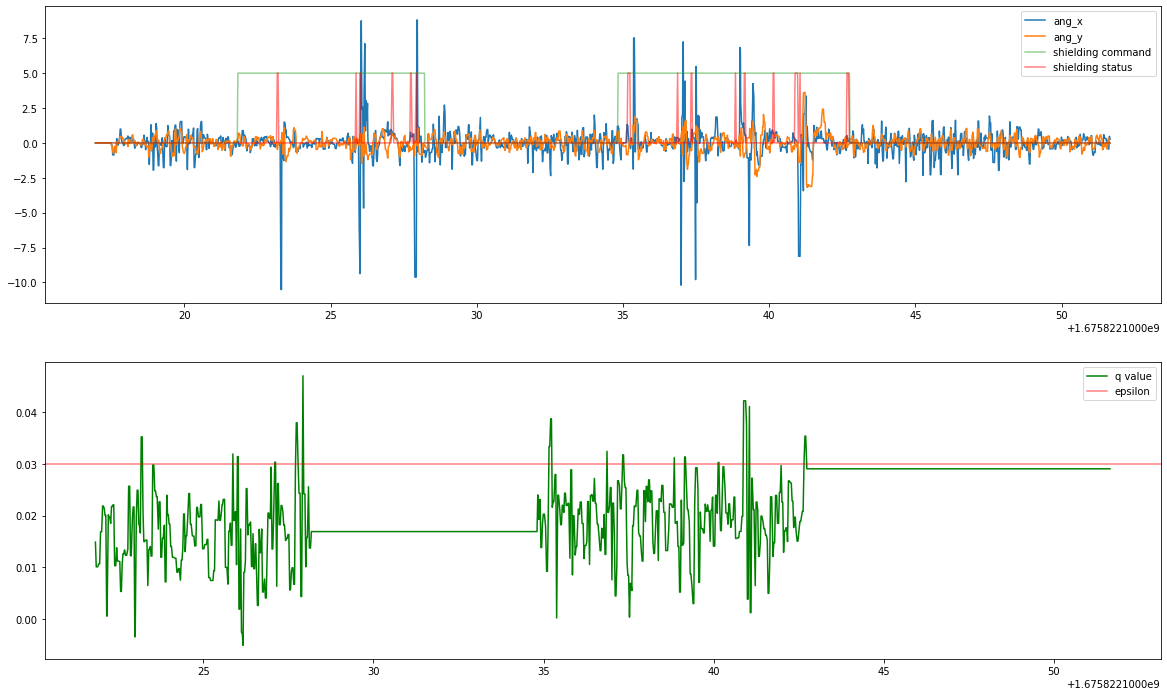

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].plot(df["time"], state_array[:, 9], label="ang_x")
ax[0].plot(df["time"], state_array[:, 10], label="ang_y")
ax[0].plot(df["time"], shielding_command * 5, label="shielding command", alpha=0.5)
ax[0].plot(df["time"], shielding_status * 5, label="shielding status", color="red", alpha=0.5)
ax[1].plot(df["time"], df["q_array"], label="q value", color="green")
ax[1].axhline(0.03, color="red", alpha=0.5, label="epsilon")
ax[0].legend()
ax[1].legend()
plt.show()

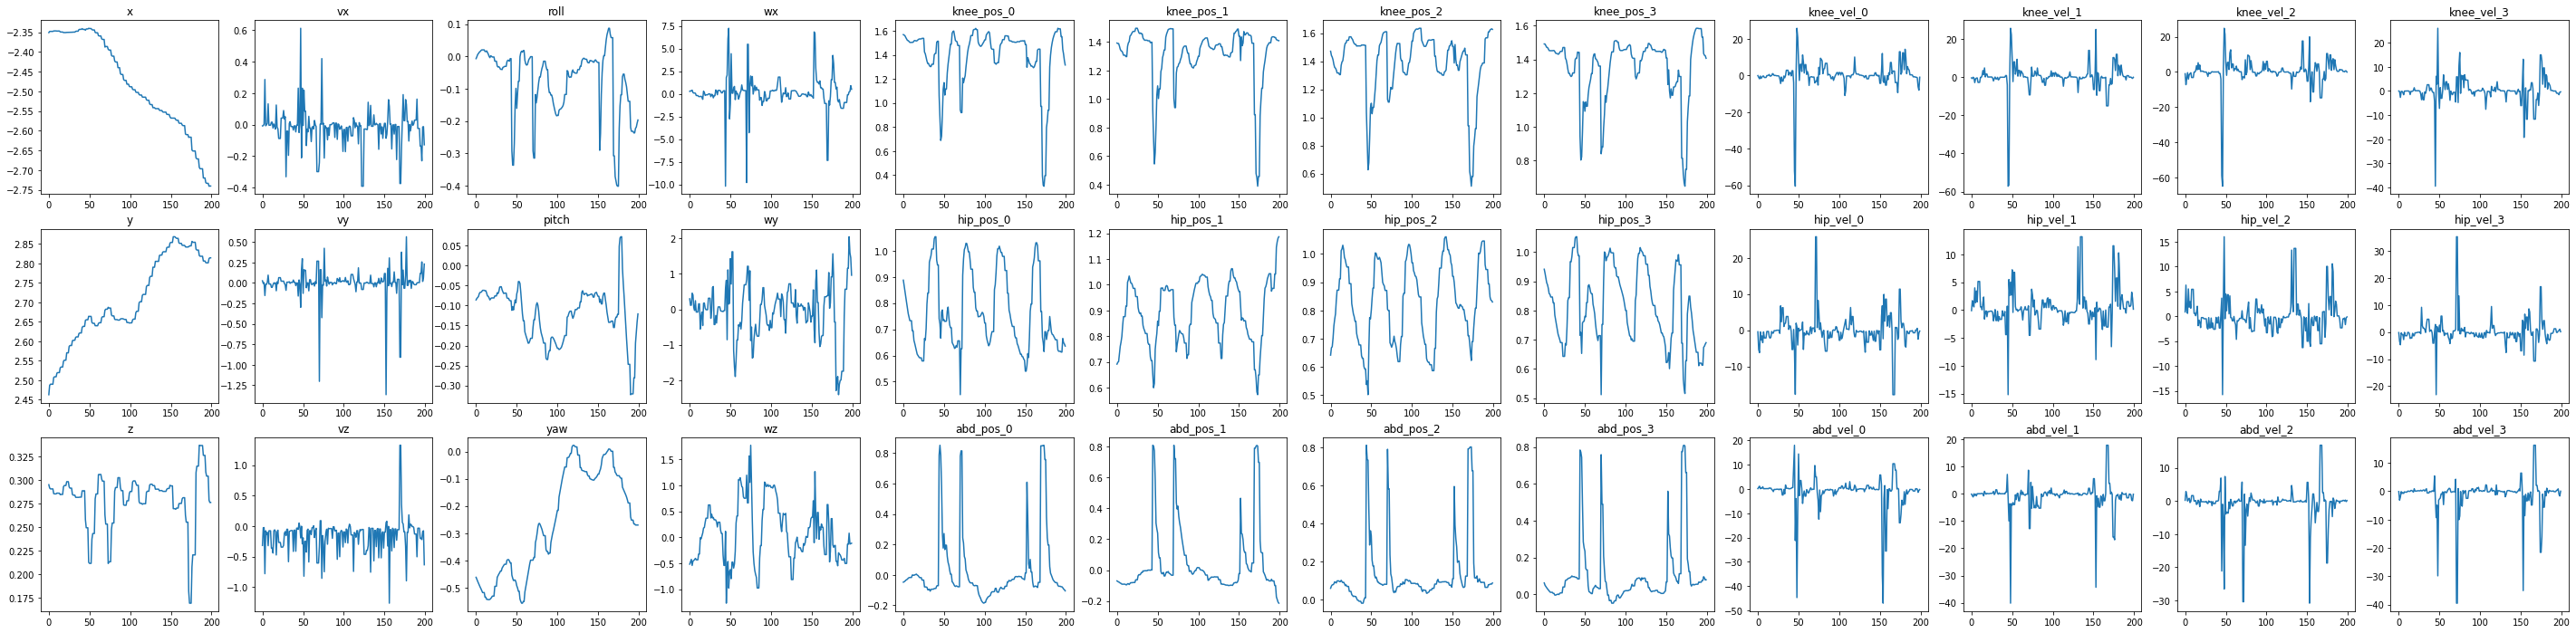

In [112]:
state_var_name = ["x", "y", "z", 
                  "vx", "vy", "vz", 
                  "roll", "pitch", "yaw", 
                  "wx", "wy", "wz",
                  "knee_pos_0", "hip_pos_0", "abd_pos_0",
                  "knee_pos_1", "hip_pos_1", "abd_pos_1",
                  "knee_pos_2", "hip_pos_2", "abd_pos_2",
                  "knee_pos_3", "hip_pos_3", "abd_pos_3",
                  "knee_vel_0", "hip_vel_0", "abd_vel_0",
                  "knee_vel_1", "hip_vel_1", "abd_vel_1",
                  "knee_vel_2", "hip_vel_2", "abd_vel_2",
                  "knee_vel_3", "hip_vel_3", "abd_vel_3",
                  ]
lim_low = 1000
lim_up = 1200

fig, ax = plt.subplots(3, 12, figsize=(50, 12))
for j in range(12):
    for i in range(3):
        ax[i][j].plot(state_array[lim_low:lim_up, j*3+i])
        ax[i][j].set_title(state_var_name[j*3+i])
plt.show()

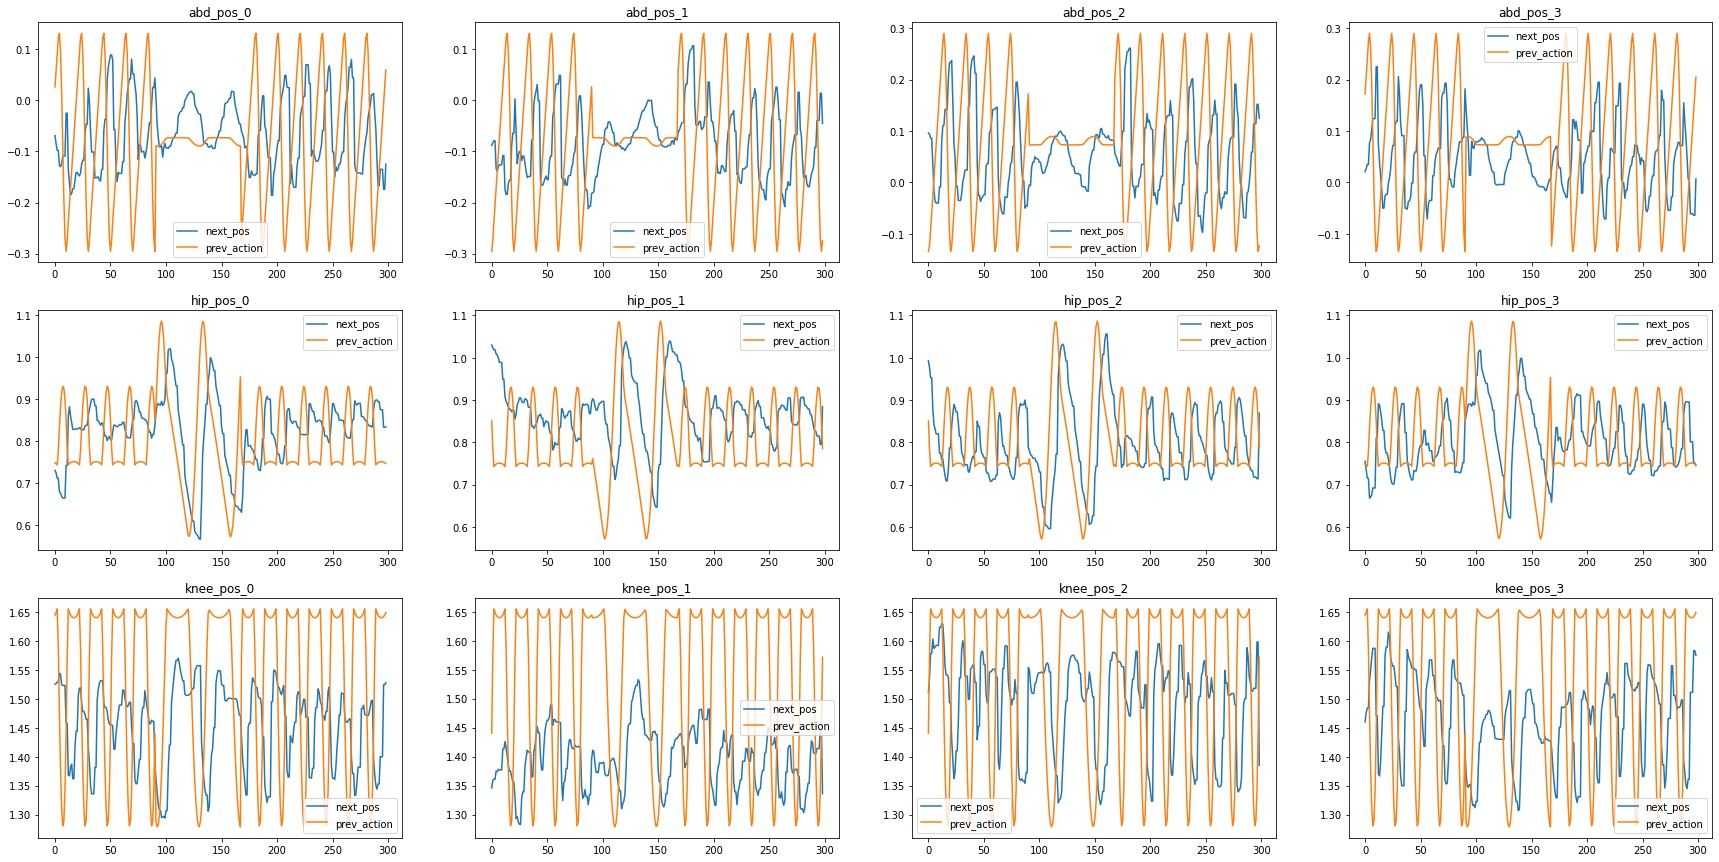

In [118]:
# check to see if prev_action = next_pos
lim_low = 600
lim_high = 900

prev_action = action_array[lim_low:lim_high-1, :]
next_pos = state_array[lim_low+1:lim_high, 12:24]

next_pos = next_pos.reshape((len(next_pos), 4, 3))
next_pos[:, :, [0, 1, 2]] = next_pos[:, :, [2, 1, 0]]
next_pos = next_pos.reshape((len(next_pos), 12))

plot_name = [
    "abd_pos_0", "hip_pos_0", "knee_pos_0",
    "abd_pos_1", "hip_pos_1", "knee_pos_1", 
    "abd_pos_2", "hip_pos_2", "knee_pos_2",
    "abd_pos_3", "hip_pos_3", "knee_pos_3"
]

fig, ax = plt.subplots(3, 4, figsize=(30, 15))
for j in range(4):
    for i in range(3):
        ax[i][j].plot(next_pos[:, j*3+i], label="next_pos")
        ax[i][j].plot(prev_action[:, j*3+i], label="prev_action")
        ax[i][j].set_title(plot_name[j*3+i])
        ax[i][j].legend()
plt.show()

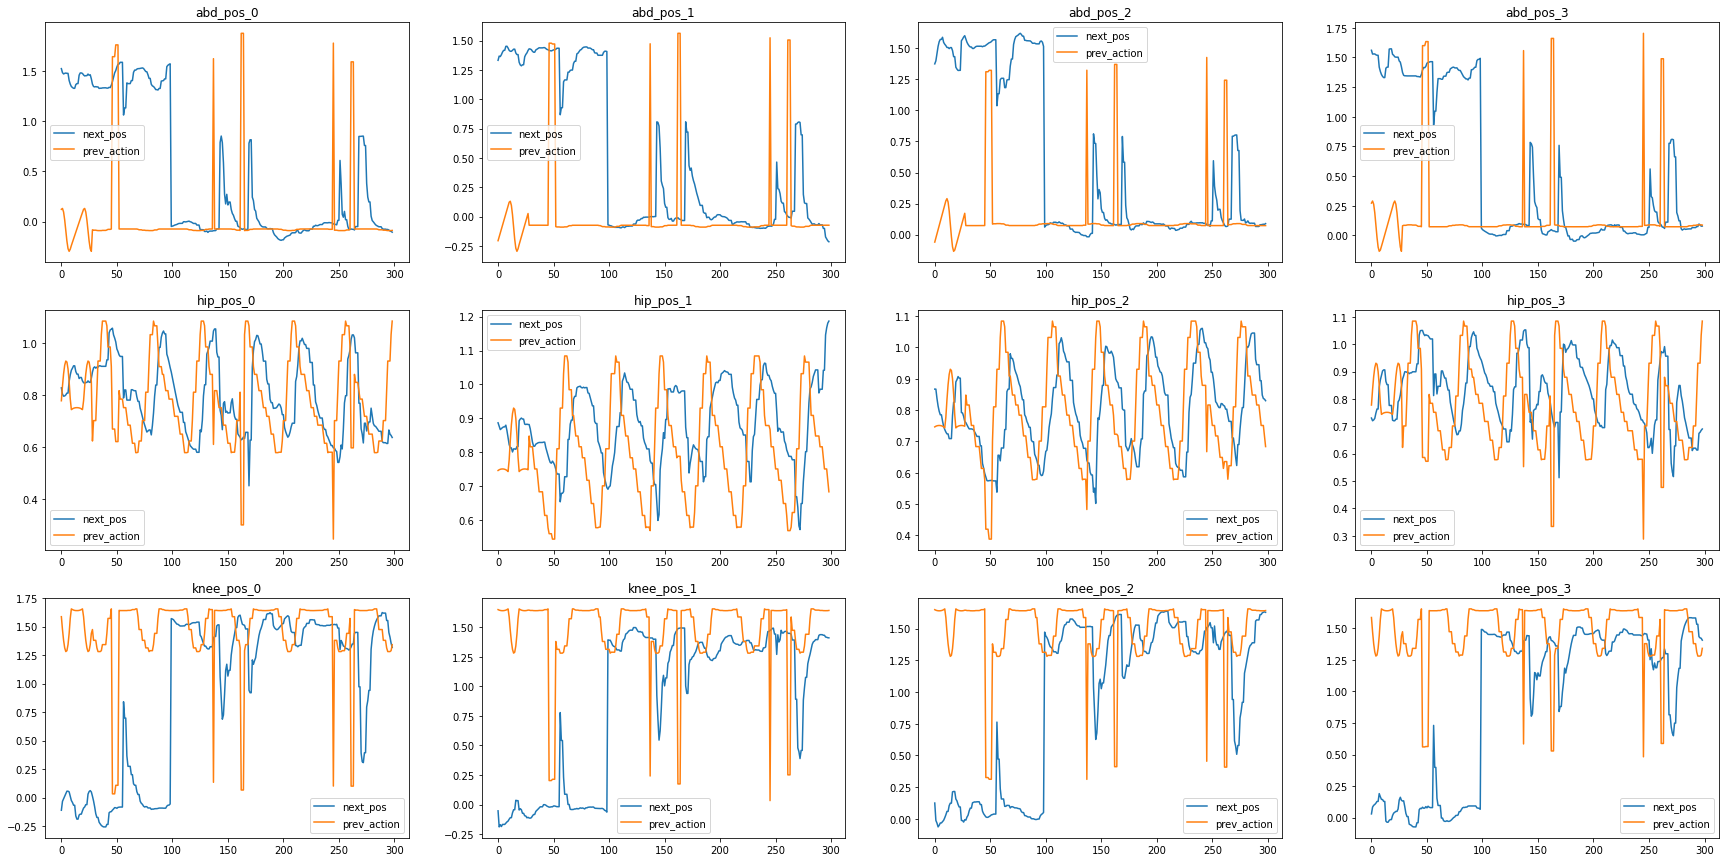

In [122]:
# check to see if prev_action = next_pos
lim_low = 900
lim_high = 1200

prev_action = action_array[lim_low:lim_high-1, :]
next_pos = state_array[lim_low+1:lim_high, 12:24]

next_pos = next_pos.reshape((len(next_pos), 4, 3))
next_pos[:, :, [0, 1, 2]] = next_pos[:, :, [2, 1, 0]]
next_pos = next_pos.reshape((len(next_pos), 12))

plot_name = [
    "abd_pos_0", "hip_pos_0", "knee_pos_0",
    "abd_pos_1", "hip_pos_1", "knee_pos_1", 
    "abd_pos_2", "hip_pos_2", "knee_pos_2",
    "abd_pos_3", "hip_pos_3", "knee_pos_3"
]

fig, ax = plt.subplots(3, 4, figsize=(30, 15))
for j in range(4):
    for i in range(3):
        ax[i][j].plot(next_pos[:, j*3+i], label="next_pos")
        ax[i][j].plot(prev_action[:, j*3+i], label="prev_action")
        ax[i][j].set_title(plot_name[j*3+i])
        ax[i][j].legend()
plt.show()